# Cycle GAN

# Conteúdo do Notebook
1. Introdução
1. Arquitetura da *Cycle GAN*
1. Treino de uma *Cycle GAN*
1. Importação das Bibliotecas
1. Load do Dataset
1. *CycleGAN*
1. Descrição Do CycleGAN
1. *Identity Mapping*
1. Modelo do Gerador (*Generator*)
1. Descrição do Gerador
1. Arquitetura do Gerador
1. Modelo do Discriminador (*Discriminator*)
1. Treino dos Geradores
1. Treino Do *CycleGAN*
1. Conclusão

## Introdução

[Paper](https://junyanz.github.io/CycleGAN/) onde o projeto foi baseado

Das opções que foram dadas decidi por fazer um *Cycle GAN*.

Uma *Cycle GAN* é uma arquitetura de rede neuronal utilizada para realizar a tradução entre dois domínios de dados diferentes, sem a necessidade de um conjunto treino supervisionado correspondente como o caso das *GAN Pix2Pix*. Um exempplo de uma *Cycle Gan* é traduzir imagens de um cavalo numa zebra e vice-versa, de paisagens diurnas em paisagens noturnas, sem ter acesso a pares correspondentes de treino.

#### Notas

Os modelos guardados e os datasets podem ser encontrados no seguinte links [Modelos](https://drive.google.com/drive/folders/1--sYMwaREbe7OZzA0A6ZUfd_3-TGzNFa?usp=sharing), assim como o [Dataset](https://drive.google.com/drive/folders/1vr4VKacoZ2V22vLOizzfBtR_3aplzyWH?usp=sharing)

O trabalho foi desenvolvido no *Google Collab* uma vez que a minha máquina pessoal não tinha recursos para fazer o treino do mesmo. Devido a esta situação irá ser encontrado partes onde os paths para os datasets, modelos etc estão como o path da drive. Gostaria de mencionar também que pelo limite de recursos da mesma, a parte de avaliação do modelo mais explicada no final do relatório não foi totalmente feita, apesar de ser possível ver as imagens geradas.

### Arquitetura da *Cycle GAN*

Este tipo de rede neuronal consiste em duas partes principais, o gerador e o discriminador. O gerador é responsável por aprender a mapear imagens do domínio de entrada para o domínio de saida, enquanto o discriminador tenta distinguir as imagens reais das imagens geradas.

No entando, o que torna a *Cycle GAN* diferente de outras *GANs* é a inclusão do ciclo consistente. Ou seja, introduz um segundo mapeamento do domínio de saida para o domínio de entrada, permitindo assim a reconstrução das imagens originais. Tal significa que a rede neuronal visa aprender duas funções de mapeamentro, uma do domínio de entrada para o domínio de saida e outra do domínio de saida para o domínio de entrada.

### Treino de uma *Cycle GAN*

Ao treinar esta rede neuronal, as imagens do domínio de entrada são alimentadas ao gerador, que tenta produzir imagens que se assemelham ao domínio de saída.</br>
O discriminador então avalia essas imagens geradas, fornecendo algum feedback para o gerador sobre a qualidade das imagens. Ao mesmo tempo as imagens do domínio de saida são usadas para reconstruir as imagens originais do domínio de entrada.

O processo de aprendizagem adversial combinado com a reconstrução do ciclo consistente, permite que a *Cycle GAN* aprenda a mapear as características relevantes entre os dois domínio, sem depender de pares correspondentes de treino.

Após o treino o gerador pode ser usado para realizar a tradução direta entre os dois domínios, permitindo que novas imagens sejam geradas no domínio de saída com base nas imagens de entrada.

 A rede neuronal *Cycle GAN* é amplamente aplicada em várias tarefas de tradução de domínio, como tradução de estilos artísticos que é o foco deste trabalho.

## Importação das Bibliotecas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.8 MB/s eta 0:00:00


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## Load do Dataset

In [5]:
main_path = "/content/drive/MyDrive/dataset/van-gogh-paintings"
#main_path = "input/van-gogh-paintings"
style_img_paths = []
for class_path in [os.path.join(main_path,class_name) for class_name in os.listdir(main_path)]:

    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        style_img_paths.append(class_img_path)

print("Existe {} categorias imagens no estilo de Van Gogh no dataset".format(len(style_img_paths)))

Existe 11 categorias imagens no estilo de Van Gogh no dataset


In [6]:
photos_path = "/content/drive/MyDrive/dataset/natural_images/natural_images"
#main_path = "input/natural_images/natural_images"
normal_image_paths = []
for class_path in [os.path.join(photos_path,class_name) for class_name in os.listdir(photos_path)]:

    #class_img_paths = glob(class_path+"/*")
    #for class_img_path in class_img_paths:
    normal_image_paths.append(class_path)

print("Existem {} categorias fotos no dataset de fotos".format(len(normal_image_paths)))

Existem 8 categorias fotos no dataset de fotos


In [7]:
style_img_path = []
for path in style_img_paths:
    for class_path in [os.path.join(path,class_name) for class_name in os.listdir(path)]:
        #for class_img_path in class_path:
        style_img_path.append(class_path)

In [8]:
normal_image_path = []
for path in normal_image_paths:
    for class_path in [os.path.join(path,class_name) for class_name in os.listdir(path)]:
        #for class_img_path in class_path:
        normal_image_path.append(class_path)

In [9]:
style_images = []

for style_path in style_img_path:
    img = cv2.imread(style_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    style_images.append(img)


print(len(style_images))


2025


In [10]:
normal_images = []

for normal_path in normal_image_path:
    img = cv2.imread(normal_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    normal_images.append(img)

print(len(normal_images))

6949


In [11]:
# Conversão para float32
style_images = np.array(style_images,dtype=np.float32)
normal_images = np.array(normal_images,dtype=np.float32)

# Fazer a escala para valores entre -1 e 1
style_images = style_images / 127.5 - 1
normal_images = normal_images / 127.5 - 1

# Realizar o Batching
style_images = tf.data.Dataset.from_tensor_slices(style_images).batch(1)
normal_images = tf.data.Dataset.from_tensor_slices(normal_images).batch(1)

As imagens estão tratadas, agora irá-se realizar uma visualização de um pequeno *sample* das mesmas

<ipython-input-12-43de503a8d43>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)


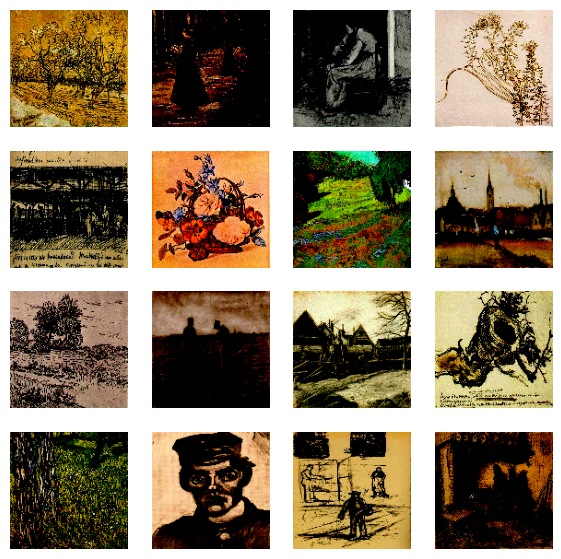

In [12]:
plt.figure(figsize=(7,7))
plt.title("Style Images")
for i,image in enumerate(style_images.shuffle(10000).take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.show()

<ipython-input-13-0f6168e8bab4>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)


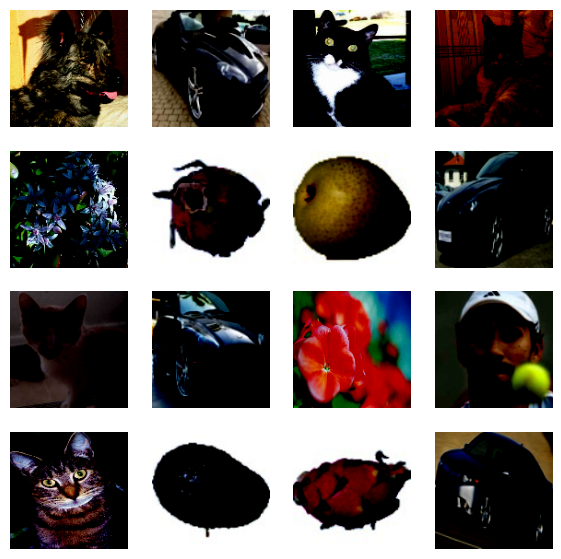

In [13]:
plt.figure(figsize=(7,7))
plt.title("Natural Images")
for i,image in enumerate(normal_images.shuffle(10000).take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    #plt.imshow(image[0])
    plt.axis("off")
plt.show()

## *CycleGAN*

### Descrição Do CycleGAN

**Consitência do Ciclo**: Os modelos de geradore são treinados para reproduzir a *source* original.
- Utilizam imagens geradas como *input* para o modelo gerador correspondente e comparam a imagem *output* com a imagem original
  - Foto -> **Gerador A** (Gera uma pintura) -> **Gerador B** (Gera uma foto)
  - Pintura -> **Gerador B** (Gera uma foto) -> **Gerador A** (Gera uma pintura)

### *Identity Mapping*
O *Identity Mapping* ocorre quando uma imagem do outro domínio é fornecida ao gerador, como se é de esperar, gera a mesma imagem.
- Pintura -> **Gerador A** -> Pintura
- Foto -> **Gerador B** -> Foto

## Funções onde se definiram os layers para o *Upsample* e para o *Downsample*

In [14]:
# we need to downsample and upsample the images, so let's write two new layers, Upsample layer and Downsample Layer
OUTPUT_CHANNELS = len(["Red","Green","Blue"])

def downsample(filters,size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))


    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())
    return result

## Modelo do Gerador (Generator)

### Descrição do Gerador

O modelo contêm dois geradores como mencionado anteriormente.

O **gerador A** gera uma imagem para o domínio A, neste caso pinturas de Van Gogh.</br>
O **gerador B** gera uma imagem para o domínio B, neste caso fotos.

O input de um gerador vem do outro domínio.
- Foto -> **Gerador A** -> Pintura de Van Gogh
- Pintura de Van Gogh -> **Gerador B** -> Foto

Cada gerador tem um modelo discriminador correspondente (**Discriminador A** e **Discriminador B**).</br>
- Pintura de Van Gogh -> **Discriminador A** -> Real/Falsa
- Foto -> **Gerador A** (Gera uma pintura) -> **Discriminador A** -> Real/Falsa

- Fotos -> Discriminador B -> Real/Falsa
- Pintura de Van Gogh -> **Gerador B** (Gera uma foto) -> **Discriminador B** -> Real/Falsa

### Arquitetura do Gerador
O gerador recebe uma imagem de entrada com o tamanho 128x128x3 (largura, altura, canais de cor) e produz uma imagem de saída com o mesmo tamanho.

A arquitetura do gerador divide-se em duas partes principais: a pilha de camadas de redução da amostragem (redução do tamanho) e a pilha de camadas de aumento da amostragem (aumento do tamanho).

A pilha de camadas de redução da amostragem é responsável por reduzir progressivamente a resolução da imagem de entrada, capturando informações de nível superior em camadas mais profundas. É constituída por várias camadas convolucionais, seguidas de normalização de instâncias e ativação ReLU com fugas. Em cada camada, o número de filtros é aumentado, enquanto o tamanho do filtro é mantido em 4x4. A primeira camada tem 128 filtros e cada camada subsequente duplica o número de filtros. O stride é definido como 2, o que reduz para metade a largura e a altura da imagem. A última camada da pilha de redução da amostragem produz uma saída de 1x1x512.

A pilha de sobreamostragem é responsável por aumentar a resolução da imagem de saída, reconstruindo gradualmente os detalhes finos da imagem. É constituída por camadas convolucionais transpostas (também conhecidas como camadas deconvolucionais), seguidas de normalização de instâncias e, opcionalmente, de ativação de dropout e ReLU. Em cada camada, o número de filtros é reduzido para metade, enquanto o tamanho do filtro é mantido em 4x4. As camadas de abandono só são aplicadas às duas primeiras camadas de sobreamostragem. A última camada de sobreamostragem produz uma saída de 64x64x64.

Após a pilha de sobreamostragem, é adicionada uma camada de convolução transposta final com ativação da tangente hiperbólica (tanh) para produzir a imagem de saída com três canais de cor (RGB). Esta camada tem um tamanho de filtro de 4x4, stride de 2 e padding de "same", o que aumenta a resolução da imagem para 128x128x3, que é a resolução da imagem de entrada.

Durante o processo de redução da amostragem, são criadas ligações de salto entre as camadas de redução da amostragem e as camadas de sobreamostragem correspondentes. Estas ligações de salto permitem que a informação de baixo nível e os pormenores finos sejam preservados e reintegrados na reconstrução da imagem.

Em resumo, o gerador consiste numa combinação de camadas de redução e de sobreamostragem que captam e reconstroem informações de diferentes escalas espaciais, resultando numa imagem de saída de alta resolução e qualidade.

In [15]:
def build_generator():
    inputs = layers.Input([128,128,3])

    down_stack = [downsample(128,4), # 64x64x128
                  downsample(256,4), # 32x32x256
                  downsample(512,4), # 16x16x512
                  downsample(512,4), # 8x8x512
                  downsample(512,4), # 4x4x512
                  downsample(512,4), # 2x2x512
                  downsample(512,4), # 1x1x512
                 ]

    up_stack = [upsample(512,4,apply_dropout=True), # 2x2
                upsample(512,4,apply_dropout=True), # 4x4
                upsample(512,4), # 8x8
                upsample(256,4), # 16x16
                upsample(128,4), # 32x32
                upsample(64,4),  # 64x64
               ]

    initializer = tf.random_normal_initializer(0.,0.02)
    last = last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    # são criadas ligações de salto como uma rede residual
    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])

    x = last(x)

    return keras.Model(inputs=inputs,outputs=x)

In [16]:
gerador = build_generator()
gerador.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 128)  6400        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 256)  524800      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 512)  2098176     ['sequential_1[0][0]']       

1. Primeiro, o gerador pegou numa imagem de 128x128x3 (esta será a nossa imagem natural) e converteu-a num vetor de 1x1x512.
1. Em seguida, o gerador aumentou a amostragem desse vetor para 128x128x3
1. Criámos ligações de salto, que evitarão o problema do gradiente de fuga.
1. E finalmente devolvemos o nosso modelo.

## Modelo do Discriminador (*Discriminator*)

O Discriminador não é nada mais nada menos do que uma rede de classificação com base no *CNN*. Este determina se a imagem é real ou gerada.


### Arquitetura do Discriminador
O discriminador recebe uma imagem de entrada de tamanho 128x128x3 (largura, altura, canais de cor) e produz uma saída que representa a probabilidade de a imagem ser verdadeira ou falsa.

A arquitetura do discriminador consiste em camadas convolucionais e outras operações para extrair características discriminativas da imagem de entrada:

A imagem de entrada é definida como um tensor de entrada.
A imagem de entrada é definida como um tensor de entrada. A imagem de entrada é então passada através de duas camadas de redução da amostragem para captar características de nível superior. A primeira camada de redução da amostra tem 64 filtros e a segunda camada tem 128 filtros. Cada camada utiliza uma camada convolucional sem normalização de instância e ativação ReLU.
Após a segunda camada de redução da amostra, é adicionada uma camada de preenchimento zero.
De seguida, é aplicada uma camada convolucional com 512 filtros, um tamanho de filtro de 4x4, um stride de 1 e sem utilização de polarização (use_bias=False). Segue-se uma camada de normalização de instâncias para normalizar as activações.
A função de ativação LeakyReLU é aplicada às activações normalizadas.
Outra camada de preenchimento zero é adicionada após a camada de ativação.
Finalmente, é aplicada uma camada convolucional para reduzir a saída a um único valor que representa a probabilidade de a imagem ser verdadeira ou falsa. Esta camada tem 1 filtro, um tamanho de filtro de 4x4 e um tamanho de passo de 1.
A arquitetura resultante é um discriminador que recebe uma imagem de entrada e produz uma saída que representa a probabilidade de a imagem ser verdadeira ou falsa.

In [17]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    inp = layers.Input([128,128,3],name="input_image")

    x = inp

    down1 = downsample(64,4,False)(x) # 64x64x64
    down2 = downsample(128,4,False)(down1) # 32x32x128

    zero_pad1 = layers.ZeroPadding2D()(down2)

    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=inp,outputs=last)



In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 64, 64, 64)        3072      
                                                                 
 sequential_14 (Sequential)  (None, 32, 32, 128)       131072    
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 31, 31, 512)       1048576   
                                                                 
 instance_normalization_13 (  (None, 31, 31, 512)      1024      
 InstanceNormalization)                                    

In [19]:
vangogh_generator = build_generator() # gera pinturas de van gogh utilizando fotos
photo_generator = build_generator() # gera fotos utilizando pinturas de van gogh

vangogh_discriminator = build_discriminator() # determina se a pintura de van gogh é real ou gerado
photo_discriminator = build_discriminator() # determina se a foto é real ou gerado

In [20]:
vangogh_generator.compile()
photo_generator.compile()

vangogh_discriminator.compile()
photo_discriminator.compile()

## Modelo CycleGAN
A arquitetura do modelo CycleGAN consiste em dois geradores (um para converter imagens de Van Gogh em fotografias e outro para converter fotografias em imagens de Van Gogh) e dois discriminadores (um para distinguir imagens de Van Gogh reais de imagens falsas geradas e outro para distinguir imagens de fotografias reais de imagens falsas geradas).

Segue-se uma visão geral da arquitetura do modelo e do procedimento de treino:

Construção do modelo:

O modelo CycleGAN é inicializado com os geradores e discriminadores predefinidos: vangogh_generator, photo_generator, vangogh_discriminator e photo_discriminator.
A variável lambda_cycle é utilizada para controlar o peso da perda de ciclos durante o treino.
Compilação do modelo:

São definidos optimizadores para os geradores e discriminadores: v_gen_optimiser, p_gen_optimiser, v_disc_optimiser e p_disc_optimiser.
São definidas funções de perda para geradores e discriminadores: gen_loss_fn e disc_loss_fn.
As funções de perda para perda de ciclo e perda de identidade são definidas: cycle_loss_fn e identity_loss_fn.
Chamada de modelo:

A função de chamada é definida para direcionar a imagem de entrada ao longo de um caminho através do gerador de Van Gogh para fotografias e, em seguida, ao longo do caminho inverso através do gerador de fotografias para Van Gogh. Isto produz uma imagem em ciclo.
Passo de treino:

Na função train_step, o modelo recebe um lote de dados contendo imagens e fotografias reais de Van Gogh.
Utilizando uma banda de gradiente para traçar as operações, são executados vários passos:
As imagens reais de Van Gogh são convertidas em fotografias utilizando o gerador de Van Gogh para fotografia, e as fotografias geradas são convertidas novamente em imagens de Van Gogh utilizando o gerador de fotografia para Van Gogh.
As imagens fotográficas reais são convertidas em imagens de Van Gogh utilizando o gerador de fotografias de Van Gogh e as imagens de Van Gogh geradas são convertidas em fotografias utilizando o gerador de fotografias de Van Gogh.
Os geradores são treinados para gerar imagens que enganam os discriminadores, minimizando as perdas do discriminador nas imagens falsas geradas.
As perdas de ciclo são calculadas entre as imagens reais de Van Gogh e as imagens cicladas, e entre as imagens fotográficas reais e as imagens cicladas.
As perdas de identidade são calculadas entre as imagens reais e as imagens geradas pelos mesmos geradores.
Os discriminadores são treinados para distinguir corretamente as imagens reais das imagens falsas, minimizando as perdas dos discriminadores.
Os gradientes são calculados e aplicados aos geradores e discriminadores utilizando os optimizadores apropriados.
Regresso da etapa de formação:

A função train_step devolve um dicionário que contém as perdas do gerador de Van Gogh, as perdas do gerador de fotografias, as perdas do discriminador de Van Gogh e as perdas do discriminador de fotografias.
Esta é a arquitetura básica do modelo CycleGAN, em que os geradores e os discriminadores são treinados de forma contraditória para aprender a converter imagens de um domínio para outro, sem necessidade de pares de treino correspondentes.

In [21]:
 class CycleGAN(keras.Model):

    def __init__(self, vangogh_generator, photo_generator, vangogh_discriminator, photo_discriminator, lambda_cycle = 10):
        super(CycleGAN,self).__init__()
        self.v_gen = vangogh_generator
        self.p_gen = photo_generator
        self.v_disc = vangogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle


    def compile(self, v_gen_optimizer, p_gen_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn, v_disc_optimizer):
        super(CycleGAN,self).compile()
        self.v_gen_optimizer = v_gen_optimizer
        self.p_gen_optimizer =  p_gen_optimizer
        self.v_disc_optimizer  = v_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.p_disc_optimizer = p_disc_optimizer

    def call(self, inputs):
        generated_image = self.generator_A_to_B(inputs)
        cycle_image = self.generator_B_to_A(generated_image)
        return cycle_image

    def train_step(self,batch_data):
        real_vangogh,real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Foto -> Pintura -> Foto
            fake_vangogh = self.v_gen(real_photo,training=True)
            cycled_photo = self.p_gen(fake_vangogh,training=True)

            # vangogh to photo back to vangogh
            # Pintura -> Foto -> Pintura
            fake_photo = self.p_gen(real_vangogh,training=True)
            cycled_vangogh = self.v_gen(fake_photo,training=True)

            # Os geradores geram sozinhos
            same_photo = self.p_gen(real_photo,training=True)
            same_vangogh = self.v_gen(real_vangogh,training=True)

            # Os discriminadores vão avaliar as imagens
            disc_real_vangogh = self.v_disc(real_vangogh,training=True)
            disc_real_photo = self.p_disc(real_photo,training=True)

            disc_fake_vangogh = self.v_disc(fake_vangogh,training=True)
            disc_fake_photo = self.p_disc(fake_photo,training=True)

            # Cáluclo da loss dos geradores
            vangogh_gen_loss = self.gen_loss_fn(disc_fake_vangogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cálculo da loss total de 'cycle'
            total_cycle_loss = self.cycle_loss_fn(real_vangogh,cycled_vangogh,self.lambda_cycle) + self.cycle_loss_fn(real_photo,cycled_photo,self.lambda_cycle)

            # Cálculo da loss total
            total_vangogh_gen_loss = vangogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vangogh, same_vangogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # computing discriminator loss
            # Cálculo da loss dos discriminadores
            vangogh_disc_loss = self.disc_loss_fn(disc_real_vangogh,disc_fake_vangogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo,disc_fake_photo)


        # Cálculo dos gradientes da rede
        vangogh_generator_gradients = tape.gradient(total_vangogh_gen_loss,self.v_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)

        vangogh_discriminator_gradients = tape.gradient(vangogh_disc_loss,self.v_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)

        self.v_gen_optimizer.apply_gradients(zip(vangogh_generator_gradients,self.v_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))

        self.v_disc_optimizer.apply_gradients(zip(vangogh_discriminator_gradients,
                                                  self.v_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "v_gen_loss": total_vangogh_gen_loss,
            "p_gen_loss": total_photo_gen_loss,
            "v_disc_loss": vangogh_disc_loss,
            "p_disc_loss": photo_disc_loss
        }



# Definições dos Optimizadores e Funções de Loss

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(real,generated):

    real_loss = cross_entropy(tf.ones_like(real),real)
    generated_loss = cross_entropy(tf.zeros_like(generated),generated)

    total_loss = real_loss + generated_loss

    return total_loss * 0.5


Como no discriminador se fez o *catch* da *loss* das imagens reais e imagens gerais e somam-se um ao outro.

In [23]:
def generator_loss(generated):
    return cross_entropy(tf.ones_like(generated),generated)


Quando se trata de calcular a loss do gerador, utilizamos apenas a loss das imagens geradas (falsas).

In [24]:
def cycle_loss(real_image,cycled_image,LAMBDA):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image,same_image,LAMBDA):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA

In [25]:
# Utilização do optimizador Adam
vangogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

vangogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Treino do Modelo
Nesta etapa realiza-se a construção de um objeto da classe CycleGan, que vai ser utilizado para treinar ambos os geradores assim como ambos os discrminadores de uma forma ciclica.

## Treino dos Geradores

O gerador é treinado através do modelo combinado de forma a minimizar as 4 *losses*

- *Adversarial Loss (L2-MSE)*: Minimizar a *loss* prevista pelo discriminador para as imagens geradas marcadas como "reais"
- *Identity Loss (L1-MAE)*: Envia a imagem *source* tal como é na translação
- *Cycle Loss Forward (L1-MAE)*: A regeneração da imagem *source* quando é utilizada com o modelo (Gerador foto para pintura)
- *Cycle Loss Backward (L1-MAE)*: A regeneração da imagem *source* quando é utilizada com o modelo (Gerador pintura para foto)

In [31]:
model = CycleGAN(vangogh_generator=vangogh_generator,
                photo_generator=photo_generator,
                vangogh_discriminator=vangogh_discriminator,
                photo_discriminator=photo_discriminator
                )

checkpoint_path = '/content/drive/MyDrive/modelo/checkpoints/cycle_gan.ckpt'

# Definir o ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch'
)

# Adicionar o checkpointer callback ao model
cycle_gan_model = CycleGAN(vangogh_generator, photo_generator, vangogh_discriminator, photo_discriminator, lambda_cycle=10)

cycle_gan_model.compile(v_gen_optimizer=vangogh_generator_optimizer,
              p_gen_optimizer=photo_generator_optimizer,
              p_disc_optimizer=photo_discriminator_optimizer,
              v_disc_optimizer=vangogh_discriminator_optimizer,
              gen_loss_fn=generator_loss,
              disc_loss_fn=discriminator_loss,
              cycle_loss_fn=cycle_loss,
              identity_loss_fn=identity_loss
             )

O modelo está criado, realiza-se então o *fit* do mesmo durante 20 *epochs*. Este número foi escolhido pois foram realizados testes com um menor e com um maior número de *epochs* mas a *loss* dos discriminadores era maior ou menor do que 50% (aproximadamente), respetivamente.

In [32]:
#if os.path.exists("/content/drive/MyDrive/dataset/modelo/cycle_gan_model.h5"):
    #cycle_gan_model.load_weights("./cycle_gan_model.h5")
    #print("Weights guardados loaded")

cycle_gan_model.fit(tf.data.Dataset.zip((style_images,normal_images)),
          epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 8.0902 - p_gen_loss: 7.3877 - v_disc_loss: 0.5836 - p_disc_loss: 0.5849

2025/2025 [==============================] - 737s 332ms/step - v_gen_loss: 8.0893 - p_gen_loss: 7.3867 - v_disc_loss: 0.5837 - p_disc_loss: 0.5848
Epoch 2/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 6.2488 - p_gen_loss: 5.9831 - v_disc_loss: 0.6097 - p_disc_loss: 0.6028

2025/2025 [==============================] - 674s 333ms/step - v_gen_loss: 6.2483 - p_gen_loss: 5.9825 - v_disc_loss: 0.6097 - p_disc_loss: 0.6027
Epoch 3/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 5.4381 - p_gen_loss: 5.2563 - v_disc_loss: 0.5882 - p_disc_loss: 0.5896

2025/2025 [==============================] - 672s 332ms/step - v_gen_loss: 5.4384 - p_gen_loss: 5.2564 - v_disc_loss: 0.5882 - p_disc_loss: 0.5895
Epoch 4/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 5.1583 - p_gen_loss: 4.9341 - v_disc_loss: 0.5699 - p_disc_loss: 0.5744

2025/2025 [==============================] - 673s 332ms/step - v_gen_loss: 5.1586 - p_gen_loss: 4.9343 - v_disc_loss: 0.5699 - p_disc_loss: 0.5744
Epoch 5/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 5.0578 - p_gen_loss: 4.7846 - v_disc_loss: 0.5448 - p_disc_loss: 0.5630

2025/2025 [==============================] - 678s 335ms/step - v_gen_loss: 5.0581 - p_gen_loss: 4.7847 - v_disc_loss: 0.5448 - p_disc_loss: 0.5629
Epoch 6/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 5.0247 - p_gen_loss: 4.7235 - v_disc_loss: 0.5257 - p_disc_loss: 0.5438

2025/2025 [==============================] - 671s 331ms/step - v_gen_loss: 5.0246 - p_gen_loss: 4.7233 - v_disc_loss: 0.5257 - p_disc_loss: 0.5438
Epoch 7/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.9008 - p_gen_loss: 4.6446 - v_disc_loss: 0.5354 - p_disc_loss: 0.5373

2025/2025 [==============================] - 674s 333ms/step - v_gen_loss: 4.9011 - p_gen_loss: 4.6446 - v_disc_loss: 0.5354 - p_disc_loss: 0.5373
Epoch 8/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.7741 - p_gen_loss: 4.5837 - v_disc_loss: 0.5473 - p_disc_loss: 0.5317

2025/2025 [==============================] - 671s 332ms/step - v_gen_loss: 4.7742 - p_gen_loss: 4.5835 - v_disc_loss: 0.5473 - p_disc_loss: 0.5317
Epoch 9/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.6162 - p_gen_loss: 4.5052 - v_disc_loss: 0.5653 - p_disc_loss: 0.5298

2025/2025 [==============================] - 671s 331ms/step - v_gen_loss: 4.6160 - p_gen_loss: 4.5048 - v_disc_loss: 0.5654 - p_disc_loss: 0.5298
Epoch 10/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.5188 - p_gen_loss: 4.4431 - v_disc_loss: 0.5628 - p_disc_loss: 0.5255

2025/2025 [==============================] - 672s 332ms/step - v_gen_loss: 4.5186 - p_gen_loss: 4.4430 - v_disc_loss: 0.5630 - p_disc_loss: 0.5255
Epoch 11/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.4409 - p_gen_loss: 4.3924 - v_disc_loss: 0.5597 - p_disc_loss: 0.5205

2025/2025 [==============================] - 671s 332ms/step - v_gen_loss: 4.4406 - p_gen_loss: 4.3922 - v_disc_loss: 0.5599 - p_disc_loss: 0.5205
Epoch 12/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.3593 - p_gen_loss: 4.3416 - v_disc_loss: 0.5592 - p_disc_loss: 0.5199

2025/2025 [==============================] - 671s 331ms/step - v_gen_loss: 4.3589 - p_gen_loss: 4.3413 - v_disc_loss: 0.5594 - p_disc_loss: 0.5199
Epoch 13/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.3204 - p_gen_loss: 4.3075 - v_disc_loss: 0.5537 - p_disc_loss: 0.5161

2025/2025 [==============================] - 672s 332ms/step - v_gen_loss: 4.3203 - p_gen_loss: 4.3072 - v_disc_loss: 0.5539 - p_disc_loss: 0.5161
Epoch 14/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.2638 - p_gen_loss: 4.2561 - v_disc_loss: 0.5534 - p_disc_loss: 0.5166

2025/2025 [==============================] - 672s 332ms/step - v_gen_loss: 4.2638 - p_gen_loss: 4.2560 - v_disc_loss: 0.5537 - p_disc_loss: 0.5166
Epoch 15/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.2259 - p_gen_loss: 4.2145 - v_disc_loss: 0.5509 - p_disc_loss: 0.5149

2025/2025 [==============================] - 670s 331ms/step - v_gen_loss: 4.2259 - p_gen_loss: 4.2145 - v_disc_loss: 0.5512 - p_disc_loss: 0.5149
Epoch 16/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.1923 - p_gen_loss: 4.1734 - v_disc_loss: 0.5468 - p_disc_loss: 0.5144

2025/2025 [==============================] - 669s 331ms/step - v_gen_loss: 4.1922 - p_gen_loss: 4.1731 - v_disc_loss: 0.5470 - p_disc_loss: 0.5143
Epoch 17/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.1392 - p_gen_loss: 4.1143 - v_disc_loss: 0.5463 - p_disc_loss: 0.5138

2025/2025 [==============================] - 670s 331ms/step - v_gen_loss: 4.1394 - p_gen_loss: 4.1142 - v_disc_loss: 0.5465 - p_disc_loss: 0.5138
Epoch 18/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.1105 - p_gen_loss: 4.0888 - v_disc_loss: 0.5441 - p_disc_loss: 0.5128

2025/2025 [==============================] - 670s 331ms/step - v_gen_loss: 4.1105 - p_gen_loss: 4.0886 - v_disc_loss: 0.5443 - p_disc_loss: 0.5127
Epoch 19/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.0651 - p_gen_loss: 4.0518 - v_disc_loss: 0.5440 - p_disc_loss: 0.5114

2025/2025 [==============================] - 672s 332ms/step - v_gen_loss: 4.0654 - p_gen_loss: 4.0517 - v_disc_loss: 0.5441 - p_disc_loss: 0.5114
Epoch 20/20
2025/2025 [==============================] - ETA: 0s - v_gen_loss: 4.0356 - p_gen_loss: 4.0065 - v_disc_loss: 0.5417 - p_disc_loss: 0.5108

2025/2025 [==============================] - 672s 332ms/step - v_gen_loss: 4.0359 - p_gen_loss: 4.0064 - v_disc_loss: 0.5419 - p_disc_loss: 0.5107


### Guardar os pesos da Rede assim como os modelos completos

In [39]:
cycle_gan_model.save_weights("/content/drive/MyDrive/modelo/cycle_gan_model.h5")


In [40]:
vangogh_generator.save('/content/drive/MyDrive/modelo/vangogh_generator')
photo_generator.save('/content/drive/MyDrive/modelo/photo_generator')
photo_discriminator.save('/content/drive/MyDrive/modelo/photo_discriminator')
vangogh_discriminator.save('/content/drive/MyDrive/modelo/vangogh_discriminator')


### Geração e visualização de algumas pinturas

In [7]:
save_dir = '"/content/drive/MyDrive/generated_images/'
os.makedirs(save_dir, exist_ok=True)

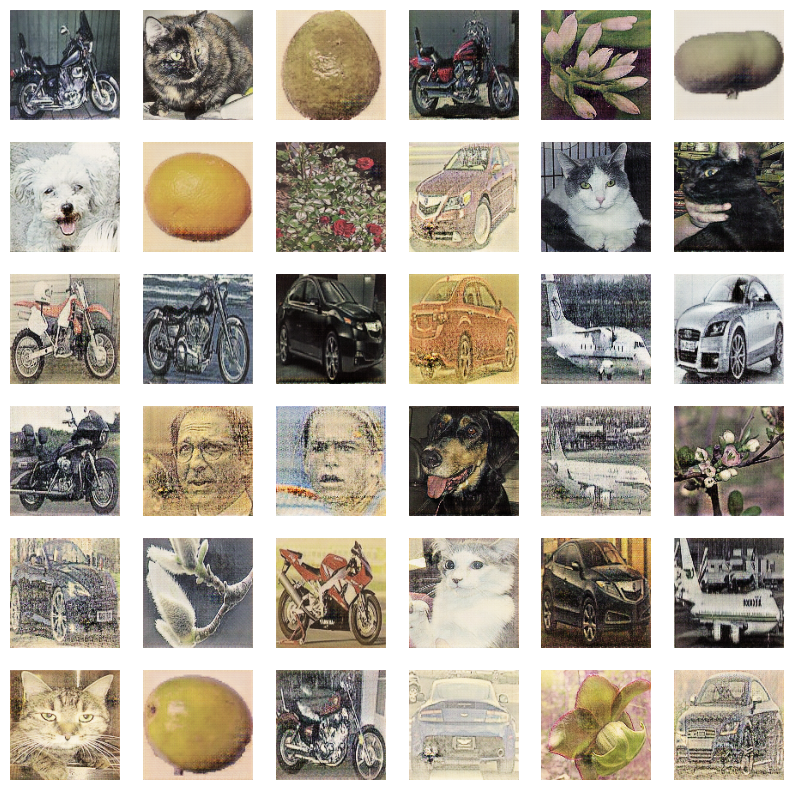

In [47]:
plt.figure(figsize=(10,10))
for i,image in enumerate(normal_images.shuffle(10000).take(36)):
    plt.subplot(6,6,i+1)
    prediction = vangogh_generator(image,training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(X = prediction)
    plt.axis("off")
    if i==36:
        break
plt.show()

### Guardar Imagens Geradas

In [ ]:
from tensorflow.keras.preprocessing import image


for i, img in enumerate(normal_images.shuffle(10000).take(100)):
    prediction = vangogh_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img_path = f"/content/drive/MyDrive/generated_images/generated_image_{i}.png"
    image.save_img(img_path, prediction)
    #print(f"Generated image {i} saved successfully at {img_path}")


# Conclusão


Como se pode ver através das imagens geradas que se encontram abaixo, existem uns fragmentos pretos nas imagens geradas e nas imagens *cycled*, uma possível solução será aumentar o *lambda*, ou diminuir o *learing rate*.

É possível notar também que existe uma perda de cor, que acontece devido a *identity loss*

Por meio das *losses* dos discriminadores repara-se que ambas estão perto dos 0.5 (50%) de acerto ou erro, o que significa que os geradores estão a gerar imagens que os discriminadores não conseguem classificar e têm de adivinhar se são geradas ou reais.

In [ ]:
# Caso se tenha o modelo treinado e se queira continuar a treinar do ponto onde parou
#checkpoint.restore(f'{checkpoint_path}-5')

## Avaliar Modelo
Não foi possível executar estas duas células devido ao tempo no google collab com a GPU ter esgotado e ter perdido os pesos do modelo. Mas como se pode verificar na imagem abaixo quando o modelo foi treinado apenas com 10 *epochs* já se tiveram resultados satisfatórios.

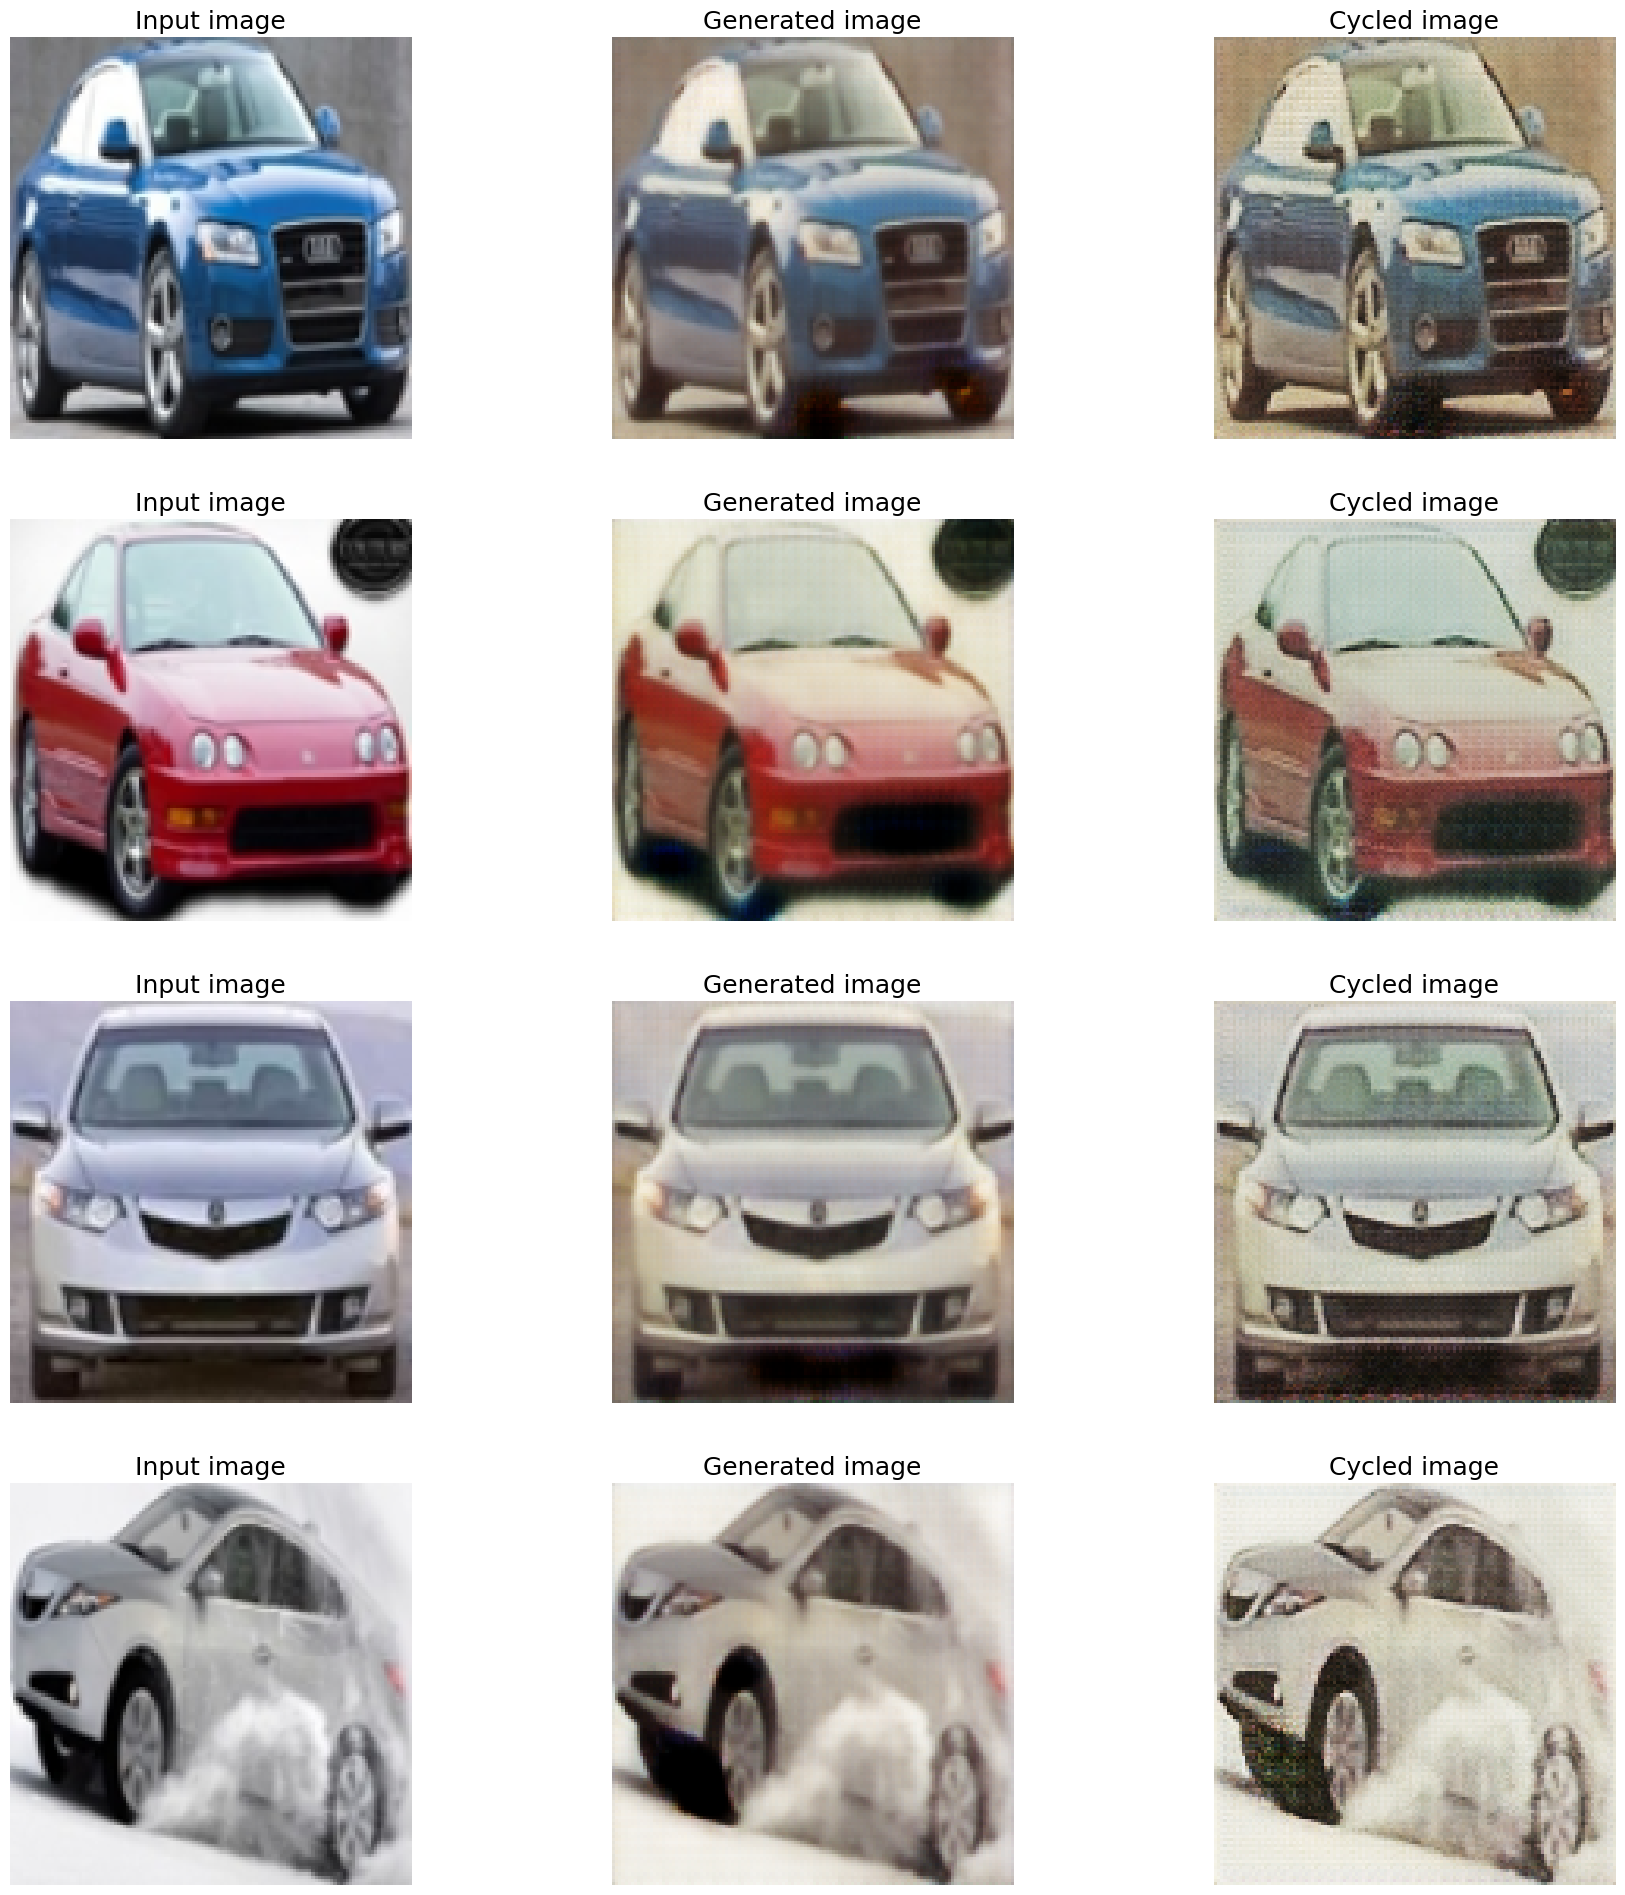

In [6]:
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()

    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)

        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')

        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')

        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')

    plt.show()

In [ ]:
evaluate_cycle(normal_images, photo_generator, vangogh_generator, n_samples=4)

In [43]:
# Load dos modelos guardados
generator_A_to_B = vangogh_generator # keras.models.load_model('path_to_generator_A_to_B')
generator_B_to_A = photo_generator # keras.models.load_model('path_to_generator_B_to_A')

# Load do dataset Van Gogh
test_dataset_A = tf.data.Dataset.list_files('/content/drive/MyDrive/dataset/teste_modelo/van_gogh/*.jpg')
test_dataset_A = test_dataset_A.map(lambda x: tf.io.read_file(x))
test_dataset_A = test_dataset_A.map(lambda x: tf.image.decode_jpeg(x, channels=3))
test_dataset_A = test_dataset_A.map(lambda x: tf.image.resize(x, [128, 128]))
test_dataset_A = test_dataset_A.map(lambda x: x / 127.5 - 1)
test_dataset_A = test_dataset_A.batch(1)

# Load do dataset Natural Images
test_dataset_B = tf.data.Dataset.list_files('/content/drive/MyDrive/dataset/teste_modelo/real_photos/*.jpg')
test_dataset_B = test_dataset_B.map(lambda x: tf.io.read_file(x))
test_dataset_B = test_dataset_B.map(lambda x: tf.image.decode_jpeg(x, channels=3))
test_dataset_B = test_dataset_B.map(lambda x: tf.image.resize(x, [128, 128]))
test_dataset_B = test_dataset_B.map(lambda x: x / 127.5 - 1)
test_dataset_B = test_dataset_B.batch(1)

# Avaliação do gerador Van Gogh para Real
def evaluate_generator_A_to_B(generator, dataset):
    num_samples = 0
    total_loss = 0.0
    generated_images = []
    ground_truth_images = []

    for image in dataset:
        generated_image = generator(image, training=False)
        cycle_image = generator_B_to_A(generated_image, training=False)

        loss = tf.reduce_mean(tf.abs(image - cycle_image))

        total_loss += loss
        num_samples += 1

        generated_images.append(generated_image[0])
        ground_truth_images.append(image[0])

        if num_samples == 10:
            break

    average_loss = total_loss / num_samples
    return average_loss, generated_images, ground_truth_images

# Avaliação do gerador Real para Van Gogh
def evaluate_generator_B_to_A(generator, dataset):
    num_samples = 0
    total_loss = 0.0
    generated_images = []
    ground_truth_images = []

    for image in dataset:
        generated_image = generator(image, training=False)
        cycle_image = generator_A_to_B(generated_image, training=False)

        loss = tf.reduce_mean(tf.abs(image - cycle_image))

        total_loss += loss
        num_samples += 1

        generated_images.append(generated_image[0])
        ground_truth_images.append(image[0])

        if num_samples == 10:
            break

    average_loss = total_loss / num_samples
    return average_loss, generated_images, ground_truth_images

# Avaliação dos geradores
loss_A_to_B, generated_images_A_to_B, ground_truth_images_A = evaluate_generator_A_to_B(generator_A_to_B, test_dataset_A)
loss_B_to_A, generated_images_B_to_A, ground_truth_images_B = evaluate_generator_B_to_A(generator_B_to_A, test_dataset_B)

print('Gerador de Imagens Reais para Estilo Van Gogh:', loss_A_to_B)
print('Gerador de Estilo Van Gogh para Imagens Reais:', loss_B_to_A)


Gerador de Imagens Reais para Estilo Van Gogh: tf.Tensor(0.4676648, shape=(), dtype=float32)
Gerador de Estilo Van Gogh para Imagens Reais: tf.Tensor(0.2397298, shape=(), dtype=float32)


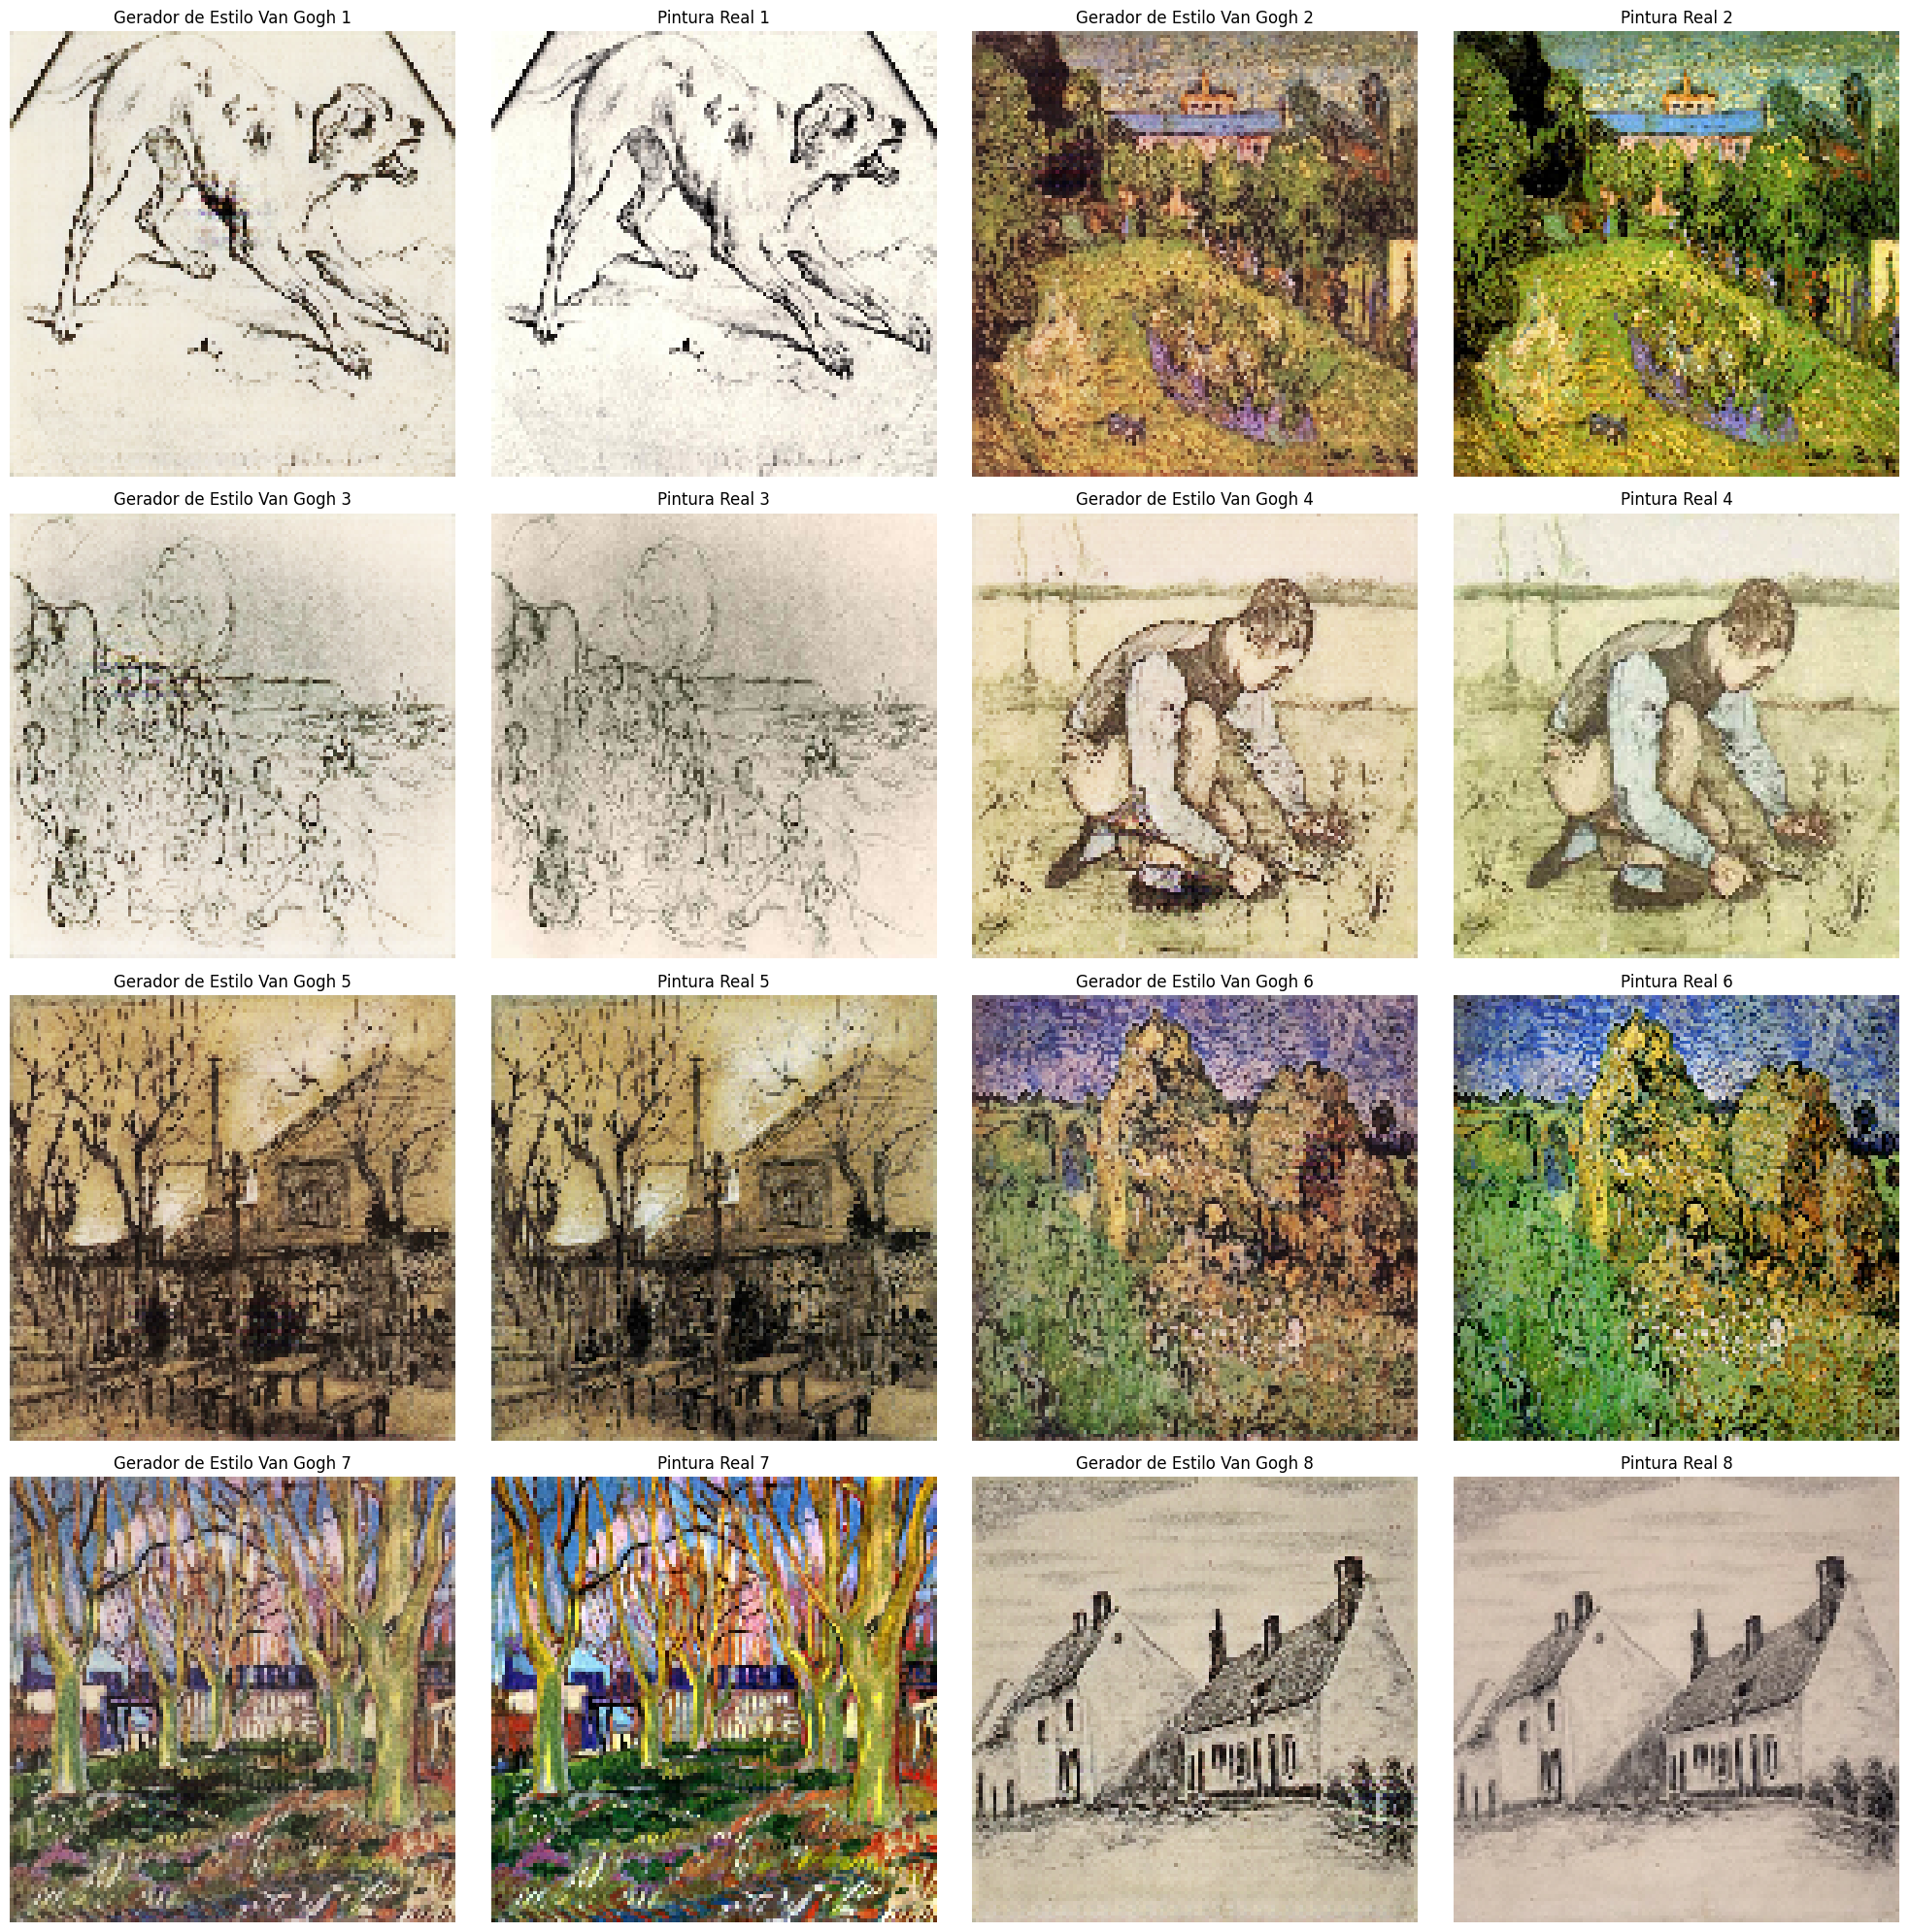

In [44]:
# Display the generated images for A-to-B along with their corresponding ground truth images
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    axes[i, 0].imshow((generated_images_A_to_B[i*2] + 1) / 2)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Gerador de Estilo Van Gogh {}'.format(i*2+1))

    axes[i, 1].imshow((ground_truth_images_A[i*2] + 1) / 2)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Pintura Real {}'.format(i*2+1))

    axes[i, 2].imshow((generated_images_A_to_B[i*2+1] + 1) / 2)
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Gerador de Estilo Van Gogh {}'.format(i*2+2))

    axes[i, 3].imshow((ground_truth_images_A[i*2+1] + 1) / 2)
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Pintura Real {}'.format(i*2+2))

plt.tight_layout()
plt.show()


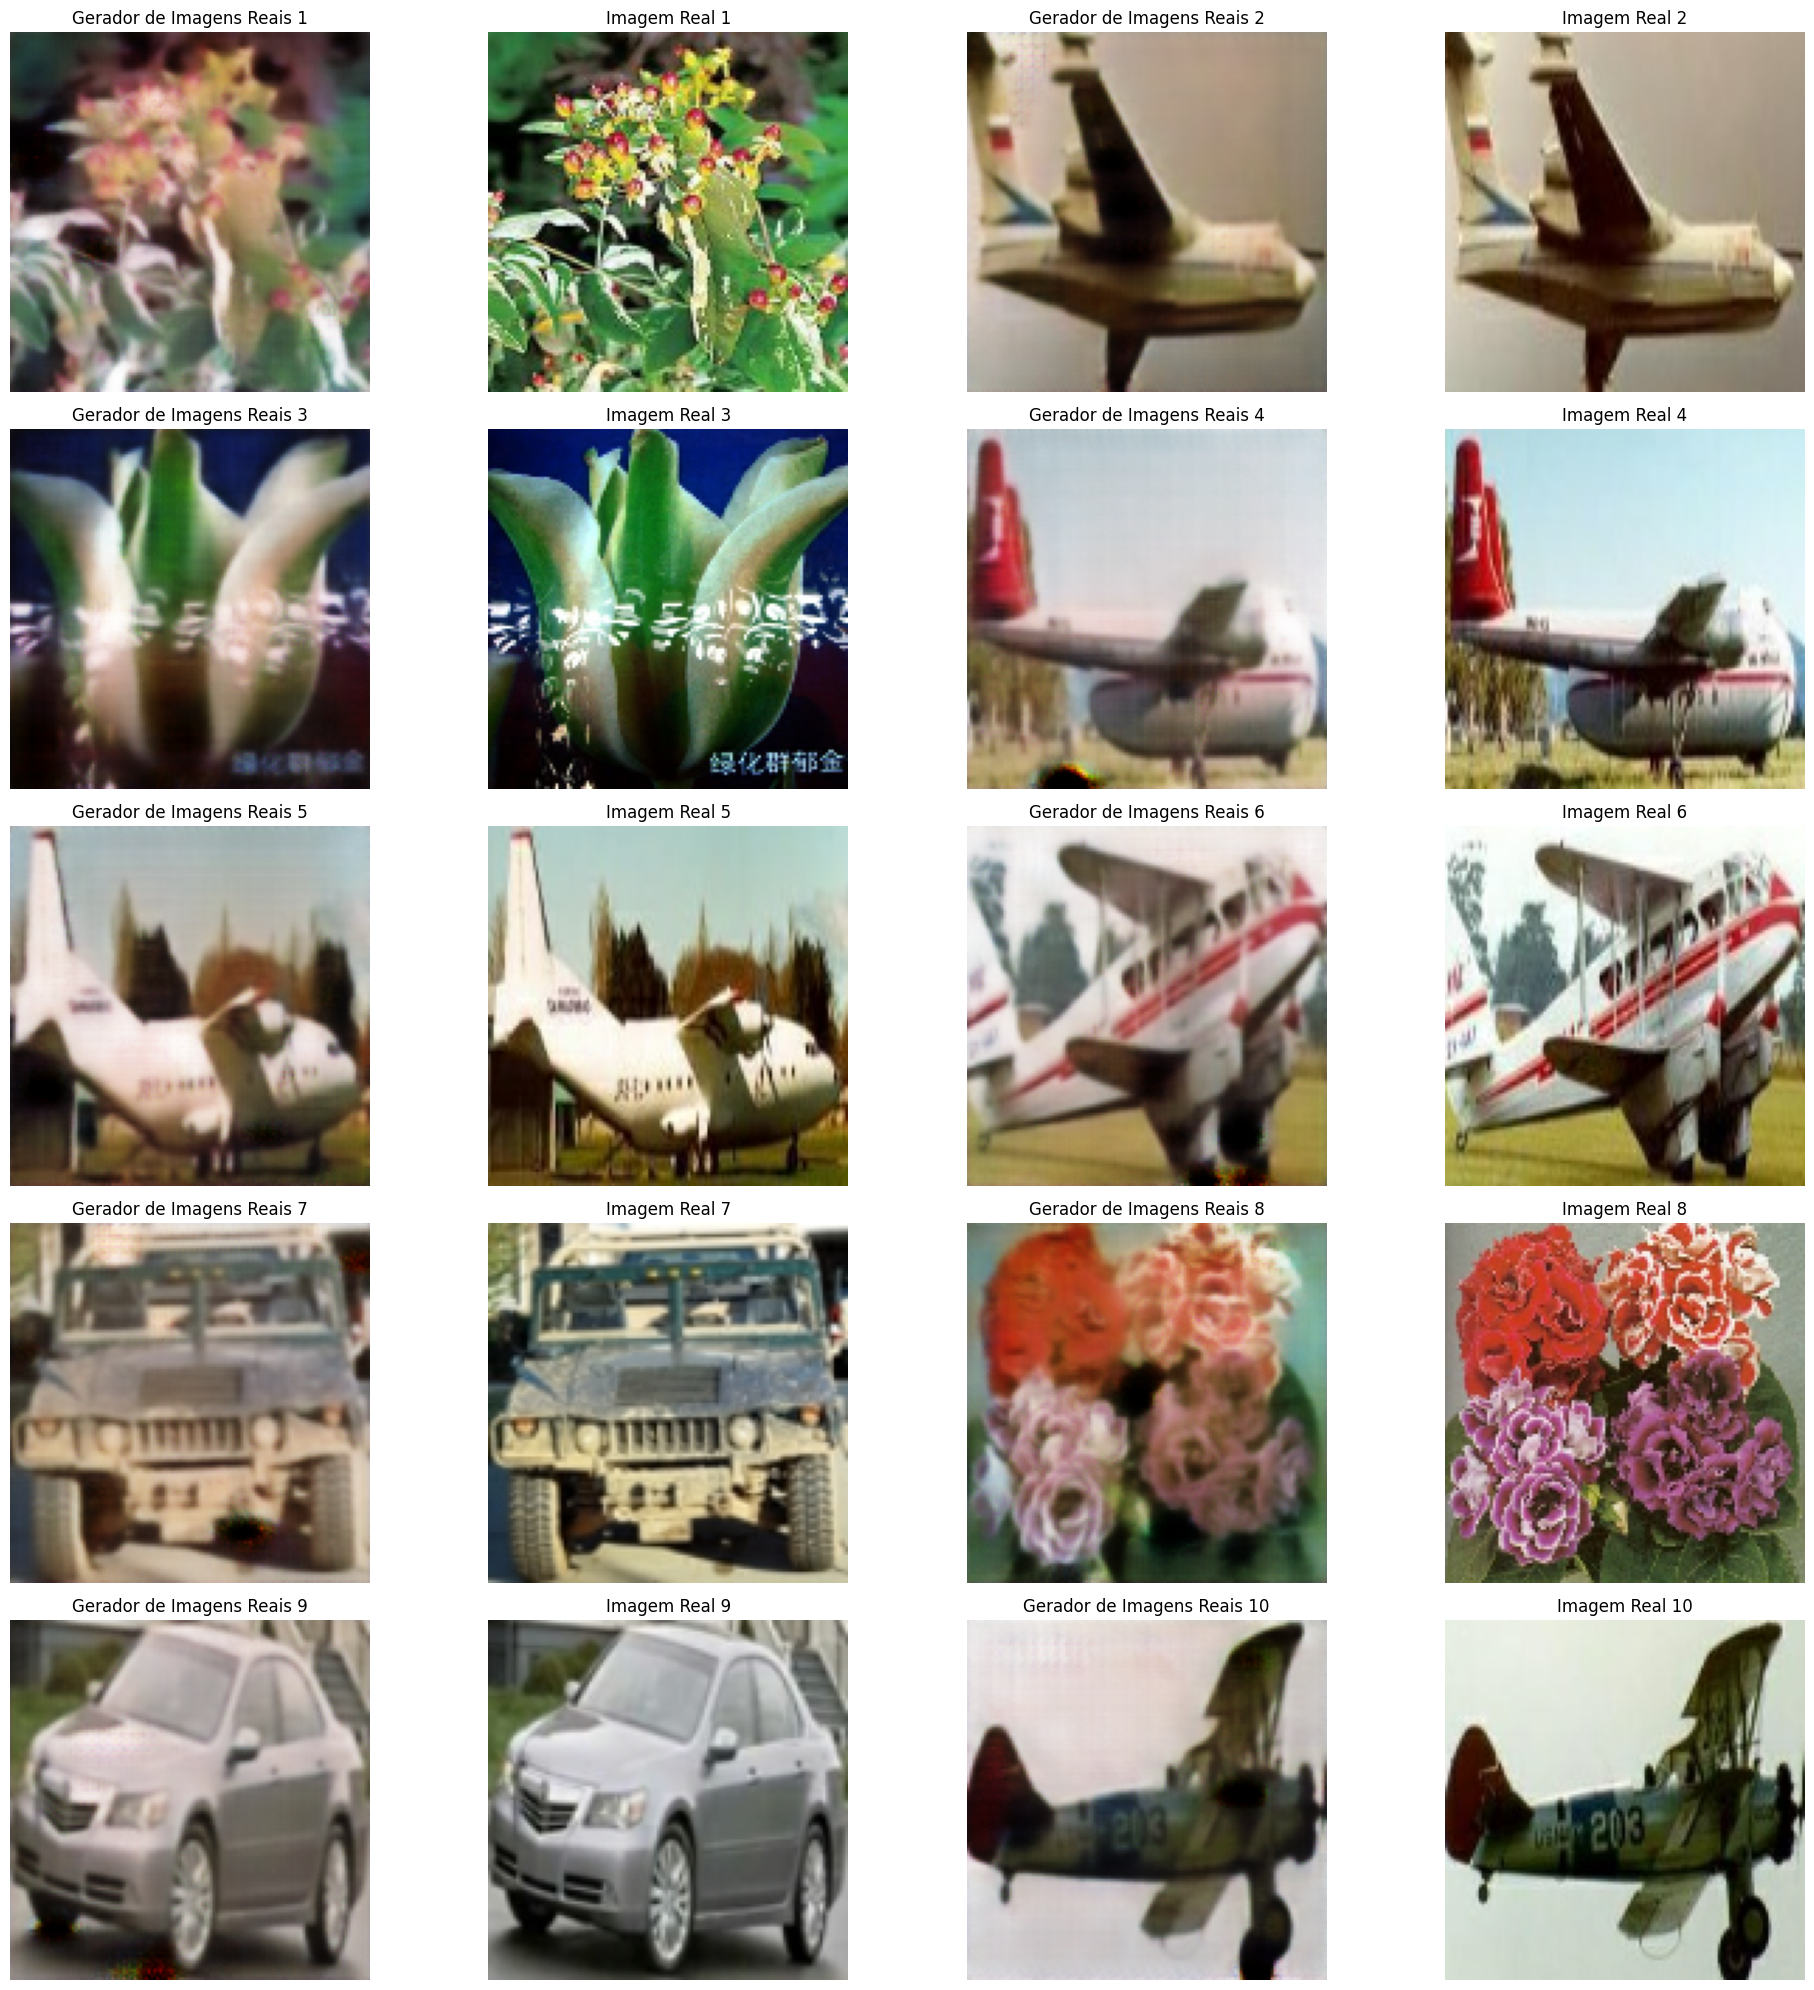

In [45]:
# Display the generated images for A-to-B along with their corresponding ground truth images
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i in range(5):
    axes[i, 0].imshow((generated_images_B_to_A[i*2] + 1) / 2)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Gerador de Imagens Reais {}'.format(i*2+1))

    axes[i, 1].imshow((ground_truth_images_B[i*2] + 1) / 2)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Imagem Real {}'.format(i*2+1))

    axes[i, 2].imshow((generated_images_B_to_A[i*2+1] + 1) / 2)
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Gerador de Imagens Reais {}'.format(i*2+2))

    axes[i, 3].imshow((ground_truth_images_B[i*2+1] + 1) / 2)
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Imagem Real {}'.format(i*2+2))

plt.tight_layout()
plt.show()